# Training sPHNN with synthetic data from a 2 mass oscillator
The sPHNN is trained with data from the following system:

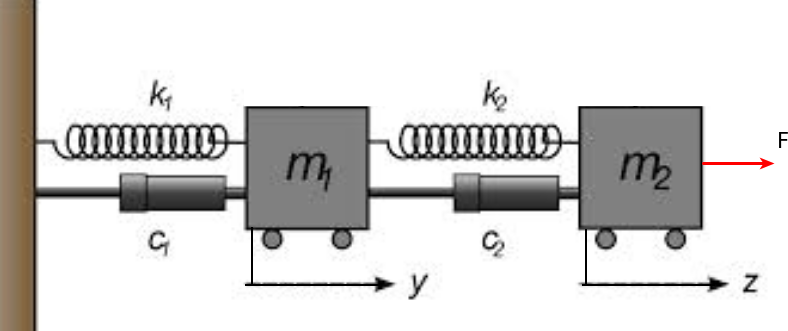

Note: I denote the state vector $\boldsymbol{y}=[q_1, q_2, v_1, v_2]^\intercal$ (would be $[y, z, \dot{y}, \dot{z}]^\intercal$ in the picture). And I use $d_i$ for the dampers and $u$ for the force instead of the $c_i$ and $F$ in the picture.

Imports

In [1]:
from dynax import ISPHS, ODESolver, LyapunovNN, aprbs
import klax

import equinox as eqx
from jaxtyping import Array
import jax
import jax.numpy as jnp
from jax import random as jr
from jax.nn.initializers import variance_scaling

import matplotlib.pyplot as plt

Define system and generate data

In [16]:
class Derivative(eqx.Module):
    """
    Derivative function of a linear two mass oscillator system, with a
    force input u acting on the second mass.
    """

    A: Array
    B: Array
    J: Array
    R: Array
    Q: Array

    def __init__(self, m1, m2, k1, k2, d1, d2):
        zeros = jnp.zeros((2, 2))

        # Structure matrix
        mass = jnp.array([[m1, 0], [0, m2]])
        mass_inv = jnp.linalg.inv(mass)
        J = jnp.block([[zeros, mass_inv], [-mass_inv, zeros]])
        self.J = J

        # Resistive matrix
        diss = jnp.array(
            [
                [(d1 + d2) / (m1 * m1), -d2 / (m1 * m2)],
                [-d2 / (m1 * m2), d2 / (m1 * m2)],
            ]
        )
        R = jnp.block([[zeros, zeros], [zeros, diss]])
        self.R = R

        # Hamililtonian quadratic form H=xQx
        Q = jnp.array(
            [[k1 + k2, -k2, 0, 0], [-k2, k2, 0, 0], [0, 0, m1, 0], [0, 0, 0, m2]]
        )
        self.Q = Q

        self.A = (J - R) @ Q

        # Input matrix
        self.B = jnp.array([0, 0, 0, 1 / m2])[:, None]

    def __call__(self, t, y, u):
        return self.A @ y + self.B @ u


deriv = Derivative(m1=1, m2=2, k1=5, k2=2, d1=0.1, d2=0.1)
true_system = eqx.filter_jit(ODESolver(deriv))

key = jr.key(0)
data_key, model_key, loader_key = jr.split(key, 3)

state_size = 4
num_ts = 200
num_trajs = 10
ts = jnp.linspace(0.0, 25.0, num_ts)
y0s = jr.uniform(data_key, (num_trajs, state_size))
us_ = jax.vmap(aprbs, in_axes=(0, None, None))(jr.split(data_key, num_trajs), num_ts, 3)
us = 1 - 2 * us_[:, :, None]
ys = jax.vmap(true_system, in_axes=(None, 0, 0))(ts, y0s, us)

Define model

In [17]:
ficnn = klax.nn.FICNN(
    in_size=state_size,
    out_size="scalar",
    width_sizes=[16, 16],
    key=model_key,
)
hamiltonian = LyapunovNN(ficnn, state_size=state_size, key=model_key)
poisson_matrix = klax.nn.ConstantSkewSymmetricMatrix(
    state_size,
    init=variance_scaling(5, "fan_avg", "truncated_normal"),
    key=model_key,
)
resistive_matrix = klax.nn.ConstantSPDMatrix(
    state_size,
    epsilon=0.0,
    init=variance_scaling(0.1, "fan_avg", "truncated_normal"),
    key=model_key,
)
input_matrix = klax.nn.ConstantMatrix(
    (state_size, 1),
    init=variance_scaling(0.0001, "fan_avg", "truncated_normal"),
    key=model_key,
)
deriv_model = ISPHS(hamiltonian, poisson_matrix, resistive_matrix, input_matrix)
model = ODESolver(deriv_model)

Train or load model parameters

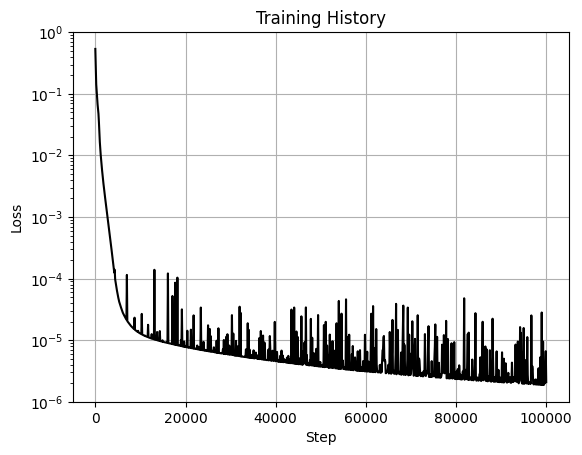

In [18]:
try:
    # Loading the model and history
    model = eqx.tree_deserialise_leaves("two_mass_oscillator_model.eqx", model)
    hist = klax.HistoryCallback.load("two_mass_oscillator_hist.pkl")
except FileNotFoundError:

    def loss_fn(model, data, batch_axis):
        ts, ys, us = data
        ys_pred = jax.vmap(model, in_axes=batch_axis)(ts, ys[:, 0], us)
        return jnp.mean(jnp.square(ys_pred - ys))

    model, hist = klax.fit(
        model,
        (ts, ys, us),
        batch_axis=(None, 0, 0),
        steps=100_000,
        loss_fn=loss_fn,
        key=model_key,
    )

    hist.save("two_mass_oscillator_hist.pkl")
    eqx.tree_serialise_leaves("two_mass_oscillator_model.eqx", model)

jitted_model = eqx.filter_jit(klax.finalize(model))
_ = jitted_model(ts, y0s[0], us[0])  # Call once to compile

hist.plot()

Plot a test prediction

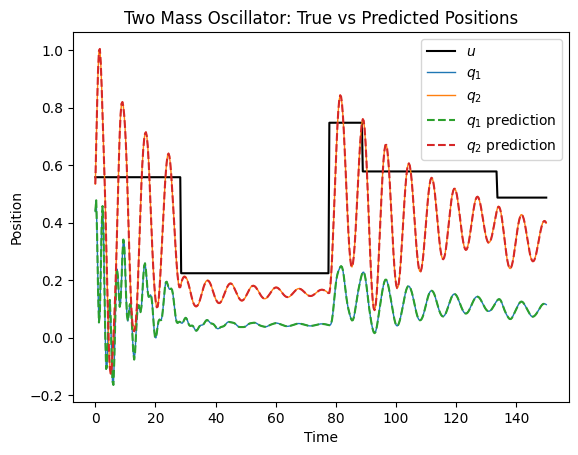

In [19]:
test_key = jr.key(1)

test_ts = jnp.linspace(0.0, 150.0, 500)
u = aprbs(test_key, test_ts.size, 4)[:, None]
y0 = jr.uniform(test_key, (state_size,))
ys_true = true_system(test_ts, y0, u)
ys_pred = jitted_model(test_ts, y0, u)

fix, ax = plt.subplots()
ax.plot(test_ts, u, label="$u$", c="black")
ax.plot(test_ts, ys_true[:, :2], label=["$q_1$", "$q_2$"], lw=1)
ax.plot(test_ts, ys_pred[:, :2], "--", label=["$q_1$ prediction", "$q_2$ prediction"])
ax.set(
    xlabel="Time",
    ylabel="Position",
    title="Two Mass Oscillator: True vs Predicted Positions",
)
ax.legend()
plt.show()